<center>
<h2 style="color:blue;font-size:30px;">Artificial Intelligence CS-414</h2>
<h3 style="color:purple">Assignment 1</h3>
 </center>
<p style="color:black;font-size:15px;">You have to design a predictor that will be trained on messages received in a chat. Collect messages data from your own whatsapp/SMS/snapchat etc (make sure that data should not contain private contents which you don’t want to disclose). There should be more than 100 training examples in the data set. Use linear predictor to predict whether second message is response of the first message?<br>

</p>
<br>
<b>Deliverables:</b>
<ol>
<li>Develop your own linear predictor and run it for different no. of iterations and plot learning curve (iterations vs loss).</li>
<li>
Use different step size and compare different learning curves in a single plot.</li>
<li>
Use built in linear predictor function from python and do the same.</li>
<li>
Compare your developed best predictors learning curve with build in linear predictor function curve.</li>
<li>
Write down a short report on analysis of results and your findings (make code, learning curves part of your report)
</li>
</ul>
<hr>

In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import math
from sklearn.metrics import log_loss

In [98]:
df=pd.read_csv("messageData.csv")
df.head(10)

,messageID,sendMessage,replyMessage,sendMessageTime,replyTimeMessage
0,1,"Hi, how was our recent trip to Gilgit?","""It was amazing! The scenery was breathtaking.""","""2023-11-03 10:00:00""","""2023-11-03 10:15:00"""
1,2,"I know, those mountains were incredible.","""Especially the view from the top.""","""2023-11-03 10:20:00""","""2023-11-03 10:25:00"""
2,3,The weather was perfect too.,"""Absolutely! Not too hot or cold.""","""2023-11-03 10:30:00""","""2023-11-03 10:35:00"""
3,4,Did you enjoy the local cuisine?,"""Yes, the food was delicious!""","""2023-11-03 10:40:00""","""2023-11-03 10:45:00"""
4,5,I still can't get over the colors of the Hunza...,"""It was like a painting.""","""2023-11-03 10:50:00""","""2023-11-03 10:55:00"""
5,6,The Baltit Fort tour was informative.,"""And the history behind it was fascinating.""","""2023-11-03 11:00:00""","""2023-11-03 11:05:00"""
6,7,The people there were so welcoming.,"""We made some new friends.""","""2023-11-03 11:10:00""","""2023-11-03 11:15:00"""
7,8,I miss those serene moments by the river.,"""Listening to the sound of water.""","""2023-11-03 11:20:00""","""2023-11-03 11:25:00"""
8,9,We should plan another trip soon.,"""Absolutely, maybe Skardu next time?""","""2023-11-03 11:30:00""","""2023-11-03 11:35:00"""
9,10,That sounds like a great idea.,"""I'm up for it!""","""2023-11-03 11:40:00""","""2023-11-03 11:45:00"""


<h4 style="color:purple">Data Preprocessing</h4>

In [99]:
df.rename(columns={'replyTimeMessage': 'replyMessageTime'}, inplace=True)

In [100]:
df.head(3)

,messageID,sendMessage,replyMessage,sendMessageTime,replyMessageTime
0,1,"Hi, how was our recent trip to Gilgit?","""It was amazing! The scenery was breathtaking.""","""2023-11-03 10:00:00""","""2023-11-03 10:15:00"""
1,2,"I know, those mountains were incredible.","""Especially the view from the top.""","""2023-11-03 10:20:00""","""2023-11-03 10:25:00"""
2,3,The weather was perfect too.,"""Absolutely! Not too hot or cold.""","""2023-11-03 10:30:00""","""2023-11-03 10:35:00"""


In [101]:
df['replyMessage'] = df['replyMessage'].apply(lambda x: re.sub(r'\"', '', x))
df['sendMessage'] = df['sendMessage'].apply(lambda x: re.sub(r'\"', '', x))
df['replyMessageTime'] = df['replyMessageTime'].apply(lambda x: re.sub(r'\"', '', x))
df['sendMessageTime'] = df['sendMessageTime'].apply(lambda x: re.sub(r'\"', '', x))
df.head(1)

,messageID,sendMessage,replyMessage,sendMessageTime,replyMessageTime
0,1,"Hi, how was our recent trip to Gilgit?",It was amazing! The scenery was breathtaking.,2023-11-03 10:00:00,2023-11-03 10:15:00


In [102]:
df['sendMessageTime'] = pd.to_datetime(df['sendMessageTime'], format='ISO8601')
df['replyMessageTime'] = pd.to_datetime(df['replyMessageTime'], format='ISO8601' )
df.head(1)


,messageID,sendMessage,replyMessage,sendMessageTime,replyMessageTime
0,1,"Hi, how was our recent trip to Gilgit?",It was amazing! The scenery was breathtaking.,2023-11-03 10:00:00,2023-11-03 10:15:00


<hr>
<h4 style="color:purple">Feature Extraction</h4>

<ul>
<li>
<h4 style="color:purple">Feature 1 : durationResponseMinutes</h4></li></ul>
<p style="color:green">Duration between Send and Response will help us to determine whether the reply message is the response of send message or not.
<ol style="color:blue">
    <li>If duration is more then 15 minutes then reply is not response of send</li>
    <li>If duration is less then 15 minutes then reply is the response of send</li>
    </ol></p>


In [103]:
df['durationResponseMinutes'] = (df['replyMessageTime'] - df['sendMessageTime']).dt.total_seconds() / 60
df.tail(5)

,messageID,sendMessage,replyMessage,sendMessageTime,replyMessageTime,durationResponseMinutes
195,196,What type of exercise are you planning to do?,Pets bring so much joy to your life.,2023-11-19 19:00:00,2023-11-19 19:30:00,30.0
196,197,I've been exploring new music genres.,Physical activity is great for health.,2023-11-19 20:00:00,2023-11-19 20:45:00,45.0
197,198,What's your favorite type of music?,Sci-fi novels can be very imaginative.,2023-11-19 21:00:00,2023-11-19 21:30:00,30.0
198,199,I've been thinking about a camping trip.,Space documentaries are mind-blowing.,2023-11-19 22:00:00,2023-11-19 22:45:00,45.0
199,200,Where do you plan to go camping?,Sports are a great way to stay active.,2023-11-19 23:00:00,2023-11-19 23:45:00,45.0


<ul>
<li>
<h4 style="color:purple">Feature 2 : keywordOverlap</h4></li></ul>
<p style="color:green">Keyword Overlap determine how much the two message is about the same topic. This give us insight that they are talking about same topic which is definitely possible in send and reply message.
<ol style="color:blue">
    <li>If keyword overlap is 0, then message is not conversation</li>
    <li>If keyword overlap is 1, then it slightly about same topic but not certainly related</li>
    <li>If keyword overlap is 2, then message is related but not identical</li>
    <li>If keyword overlap is 3, then message is are very related</li>
    </ol></p>


In [104]:
def OL_calc(sendMessage, replyMessage):
    vectorizer = TfidfVectorizer()
    vectorizer.fit([sendMessage, replyMessage])
    sendMessage_vector = vectorizer.transform([sendMessage])
    replyMessage_vector = vectorizer.transform([replyMessage])
    keyword_overlap = np.dot(sendMessage_vector.toarray(), replyMessage_vector.toarray().T)[0][0]
    return keyword_overlap

In [105]:
df['keywordOverlap'] = df[['sendMessage', 'replyMessage']].apply(lambda x: OL_calc(x['sendMessage'], x['replyMessage']), axis=1)

In [106]:
df.head(1)

,messageID,sendMessage,replyMessage,sendMessageTime,replyMessageTime,durationResponseMinutes,keywordOverlap
0,1,"Hi, how was our recent trip to Gilgit?",It was amazing! The scenery was breathtaking.,2023-11-03 10:00:00,2023-11-03 10:15:00,15.0,0.13943


<ul>
<li>
<h4 style="color:purple">Feature 3 : semanticSimilarity</h4></li></ul>
<p style="color:green">Semantic Similarity helps us to determine how two messages are similar to each other. In our case as we are checking for reply for their corresponding send message; semantic similarity value tell us how much they are similar. 
<ul style="color:blue">
   <li>0.9-1.0: Very similar</li>
<li>0.8-0.9: Similar</li>
<li>0.7-0.8: Moderately similar</li>
<li>0.6-0.7: Somewhat similar</li>
<li>0.5-0.6: Weakly similar</li>
<li>0.4-0.5: Not very similar</li>
<li>0.0-0.4: Not similar at all</li>
    </ul></p>


In [107]:
def SS_calc(sendMessage, replyMessage):
    sentence_transformer = SentenceTransformer('bert-base-nli-mean-tokens')
    sendMessage_embedding = sentence_transformer.encode(sendMessage)
    replyMessage_embedding = sentence_transformer.encode(replyMessage)
    semantic_similarity = np.dot(sendMessage_embedding, replyMessage_embedding) / (np.linalg.norm(sendMessage_embedding) * np.linalg.norm(replyMessage_embedding))
    return semantic_similarity

df['semanticSimilarity'] = df[['sendMessage', 'replyMessage']].apply(lambda x: SS_calc(x['sendMessage'], x['replyMessage']), axis=1)

In [108]:
df.head(1)

,messageID,sendMessage,replyMessage,sendMessageTime,replyMessageTime,durationResponseMinutes,keywordOverlap
0,1,"Hi, how was our recent trip to Gilgit?",It was amazing! The scenery was breathtaking.,2023-11-03 10:00:00,2023-11-03 10:15:00,15.0,0.13943


<ul>
<li>
<h4 style="color:purple">Setting Ground Truth</h4></li></ul>
<p style="color:green">I have created the dataset so I know the ground truth values of messages</p>

In [109]:
groundTruth = [1] * 100 + [0] * 100
df['groundTruth'] = groundTruth

In [110]:
df.tail(1)

,messageID,sendMessage,replyMessage,sendMessageTime,replyMessageTime,durationResponseMinutes,keywordOverlap,groundTruth
199,200,Where do you plan to go camping?,Sports are a great way to stay active.,2023-11-19 23:00:00,2023-11-19 23:45:00,45.0,0.077809,0


In [2]:
df=pd.read_csv("messagewithFeature.csv")
df.head(1)

,messageID,sendMessage,replyMessage,sendMessageTime,replyMessageTime,durationResponseMinutes,keywordOverlap,semanticSimilarity,groundTruth
0,1,"Hi, how was our recent trip to Gilgit?",It was amazing! The scenery was breathtaking.,03/11/2023 10:00,03/11/2023 10:15,15,0.13943,0.314841,1


<hr>
<h4 style="color:purple">TASKS</h4>
<ul><li>
<h4 style="color:purple">Task 1 : Linear Predictor</h4></li></ul>

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df[['durationResponseMinutes', 'keywordOverlap', 'semanticSimilarity']], df['groundTruth'], test_size=0.25)

In [38]:
duration = df['durationResponseMinutes'].values
keyword_overlap = df['keywordOverlap'].values
semantic_similarity = df['semanticSimilarity'].values
ground_truth = df['groundTruth'].values
d = 3;
data = len(df)
iteration = 1000;

In [89]:
def sF(w, i):
    x = np.array([duration[i], keyword_overlap[i], semantic_similarity[i]])  
    temp_x = w.dot(x)
    temp_x2 = -(temp_x * (ground_truth[i]))
    return np.log(1+np.exp(temp_x2))

def sdF(w, i):
    x = np.array([duration[i], keyword_overlap[i], semantic_similarity[i]])
    temp_x = w.dot(x)
    exp_term = np.exp(temp_x)
    gradient = (exp_term / (1 + exp_term) - ground_truth[i]) * x
    return gradient

In [56]:
def stochasticGradientDescent(sF, sdF, d, data, iteration, eta):
    own_losses = [];
    w = np.zeros(d)
    total_loss = 0
    for t in range(iteration):
        for i in range(data):  
            value = sF(w, i)
            gradient = sdF(w, i)
            w = w - eta * gradient
            total_loss += value
        own_losses.append(total_loss / data)
        total_loss = 0
        print('iteration {}: w = {}, F(w) = {}'.format(t, w, value))
    return own_losses

<h4 style="color:blue">Iterations vs loss</h4>

In [81]:
eta = 0.02
stochasticGradientDescent(sF, sdF, d, data, iteration, eta)

iteration 0: w = [-0.73159271  0.00469253  0.05724175], F(w) = 0.6931471805599453
iteration 1: w = [-0.76233331  0.01589488  0.18252113], F(w) = 0.6931471805599453
iteration 2: w = [-0.77393645  0.02714524  0.3092255 ], F(w) = 0.6931471805599453
iteration 3: w = [-0.78407573  0.03827746  0.43519304], F(w) = 0.6931471805599453
iteration 4: w = [-0.7926101   0.04928254  0.56028565], F(w) = 0.6931471805599453
iteration 5: w = [-0.79872698  0.06015027  0.68435643], F(w) = 0.6931471805599453
iteration 6: w = [-0.80124162  0.07086341  0.80717652], F(w) = 0.6931471805599453
iteration 7: w = [-0.79856796  0.08139434  0.92839681], F(w) = 0.6931471805599453
iteration 8: w = [-0.78882884  0.09170151  1.04750588], F(w) = 0.6931471805599453
iteration 9: w = [-0.77024205  0.1017268   1.16379831], F(w) = 0.6931471805599453
iteration 10: w = [-0.7418174   0.1113967   1.27638206], F(w) = 0.6931471805599453
iteration 11: w = [-0.70410247  0.12063038  1.3842605 ], F(w) = 0.6931471805599453
iteration 12: 

iteration 99: w = [-0.45175678  0.47591718  4.99194816], F(w) = 0.6931471805599453
iteration 100: w = [-0.45263059  0.47899883  5.01934513], F(w) = 0.6931471805599453
iteration 101: w = [-0.45350099  0.48207235  5.04659898], F(w) = 0.6931471805599453
iteration 102: w = [-0.45436801  0.48513794  5.07371117], F(w) = 0.6931471805599453
iteration 103: w = [-0.4552317   0.48819577  5.10068315], F(w) = 0.6931471805599453
iteration 104: w = [-0.45609208  0.49124604  5.12751633], F(w) = 0.6931471805599453
iteration 105: w = [-0.45694918  0.49428891  5.15421208], F(w) = 0.6931471805599453
iteration 106: w = [-0.45780305  0.49732457  5.18077177], F(w) = 0.6931471805599453
iteration 107: w = [-0.4586537   0.50035319  5.20719673], F(w) = 0.6931471805599453
iteration 108: w = [-0.45950117  0.50337495  5.23348828], F(w) = 0.6931471805599453
iteration 109: w = [-0.46034547  0.50639     5.25964769], F(w) = 0.6931471805599453
iteration 110: w = [-0.46118666  0.50939851  5.28567624], F(w) = 0.6931471805

iteration 203: w = [-0.52802499  0.77669061  7.26094706], F(w) = 0.6931471805599453
iteration 204: w = [-0.5286391   0.77954882  7.27841269], F(w) = 0.6931471805599453
iteration 205: w = [-0.52925131  0.78240836  7.29581452], F(w) = 0.6931471805599453
iteration 206: w = [-0.52986163  0.78526926  7.31315298], F(w) = 0.6931471805599453
iteration 207: w = [-0.53047006  0.78813154  7.33042845], F(w) = 0.6931471805599453
iteration 208: w = [-0.53107662  0.79099524  7.34764135], F(w) = 0.6931471805599453
iteration 209: w = [-0.53168131  0.7938604   7.36479206], F(w) = 0.6931471805599453
iteration 210: w = [-0.53228415  0.79672704  7.38188098], F(w) = 0.6931471805599453
iteration 211: w = [-0.53288515  0.79959518  7.39890849], F(w) = 0.6931471805599453
iteration 212: w = [-0.5334843   0.80246487  7.41587499], F(w) = 0.6931471805599453
iteration 213: w = [-0.53408163  0.80533612  7.43278086], F(w) = 0.6931471805599453
iteration 214: w = [-0.53467714  0.80820897  7.44962647], F(w) = 0.693147180

iteration 327: w = [-0.59227895  1.14712463  9.04034012], F(w) = 0.6931471805599453
iteration 328: w = [-0.59271843  1.1502677   9.05218473], F(w) = 0.6931471805599453
iteration 329: w = [-0.59315691  1.15341338  9.06399774], F(w) = 0.6931471805599453
iteration 330: w = [-0.5935944   1.15656166  9.07577931], F(w) = 0.6931471805599453
iteration 331: w = [-0.59403089  1.15971255  9.0875296 ], F(w) = 0.6931471805599453
iteration 332: w = [-0.59446638  1.16286605  9.09924877], F(w) = 0.6931471805599453
iteration 333: w = [-0.5949009   1.16602215  9.11093696], F(w) = 0.6931471805599453
iteration 334: w = [-0.59533443  1.16918085  9.12259433], F(w) = 0.6931471805599453
iteration 335: w = [-0.59576699  1.17234215  9.13422105], F(w) = 0.6931471805599453
iteration 336: w = [-0.59619858  1.17550605  9.14581725], F(w) = 0.6931471805599453
iteration 337: w = [-0.5966292   1.17867255  9.1573831 ], F(w) = 0.6931471805599453
iteration 338: w = [-0.59705886  1.18184163  9.16891874], F(w) = 0.693147180

iteration 431: w = [-0.63336203  1.48743377 10.12759245], F(w) = 0.6931471805599453
iteration 432: w = [-0.6337181   1.49083028 10.13683893], F(w) = 0.6931471805599453
iteration 433: w = [-0.63407352  1.494229   10.14606585], F(w) = 0.6931471805599453
iteration 434: w = [-0.63442831  1.49762992 10.15527329], F(w) = 0.6931471805599453
iteration 435: w = [-0.63478246  1.50103303 10.16446132], F(w) = 0.6931471805599453
iteration 436: w = [-0.63513598  1.50443832 10.17363004], F(w) = 0.6931471805599453
iteration 437: w = [-0.63548887  1.5078458  10.18277951], F(w) = 0.6931471805599453
iteration 438: w = [-0.63584114  1.51125546 10.19190983], F(w) = 0.6931471805599453
iteration 439: w = [-0.63619278  1.51466729 10.20102106], F(w) = 0.6931471805599453
iteration 440: w = [-0.63654379  1.51808128 10.2101133 ], F(w) = 0.6931471805599453
iteration 441: w = [-0.63689419  1.52149744 10.21918662], F(w) = 0.6931471805599453
iteration 442: w = [-0.63724397  1.52491576 10.22824109], F(w) = 0.693147180

iteration 532: w = [-0.66645178  1.84076864 10.97466013], F(w) = 0.6931471805599453
iteration 533: w = [-0.66675357  1.84436242 10.98227771], F(w) = 0.6931471805599453
iteration 534: w = [-0.66705491  1.84795791 10.98988207], F(w) = 0.6931471805599453
iteration 535: w = [-0.6673558   1.8515551  10.99747327], F(w) = 0.6931471805599453
iteration 536: w = [-0.66765624  1.85515399 11.00505135], F(w) = 0.6931471805599453
iteration 537: w = [-0.66795623  1.85875457 11.01261636], F(w) = 0.6931471805599453
iteration 538: w = [-0.66825578  1.86235684 11.02016835], F(w) = 0.6931471805599453
iteration 539: w = [-0.66855488  1.86596079 11.02770736], F(w) = 0.6931471805599453
iteration 540: w = [-0.66885354  1.86956642 11.03523344], F(w) = 0.6931471805599453
iteration 541: w = [-0.66915176  1.87317373 11.04274664], F(w) = 0.6931471805599453
iteration 542: w = [-0.66944954  1.87678271 11.05024699], F(w) = 0.6931471805599453
iteration 543: w = [-0.66974688  1.88039336 11.05773456], F(w) = 0.693147180

iteration 633: w = [-0.69486406  2.21164029 11.68432916], F(w) = 0.6931471805599453
iteration 634: w = [-0.69512642  2.21538509 11.69081668], F(w) = 0.6931471805599453
iteration 635: w = [-0.69538844  2.21913118 11.69729476], F(w) = 0.6931471805599453
iteration 636: w = [-0.69565013  2.22287857 11.70376344], F(w) = 0.6931471805599453
iteration 637: w = [-0.69591148  2.22662725 11.71022275], F(w) = 0.6931471805599453
iteration 638: w = [-0.6961725   2.23037721 11.71667271], F(w) = 0.6931471805599453
iteration 639: w = [-0.69643318  2.23412846 11.72311335], F(w) = 0.6931471805599453
iteration 640: w = [-0.69669354  2.23788098 11.7295447 ], F(w) = 0.6931471805599453
iteration 641: w = [-0.69695356  2.24163478 11.73596679], F(w) = 0.6931471805599453
iteration 642: w = [-0.69721325  2.24538986 11.74237965], F(w) = 0.6931471805599453
iteration 643: w = [-0.69747261  2.2491462  11.74878331], F(w) = 0.6931471805599453
iteration 644: w = [-0.69773164  2.25290381 11.75517779], F(w) = 0.693147180

iteration 736: w = [-0.72026385  2.60358415 12.30762458], F(w) = 0.6931471805599453
iteration 737: w = [-0.72049572  2.60744563 12.31327329], F(w) = 0.6931471805599453
iteration 738: w = [-0.72072733  2.6113081  12.318915  ], F(w) = 0.6931471805599453
iteration 739: w = [-0.72095869  2.61517155 12.32454971], F(w) = 0.6931471805599453
iteration 740: w = [-0.72118978  2.61903597 12.33017746], F(w) = 0.6931471805599453
iteration 741: w = [-0.72142062  2.62290137 12.33579825], F(w) = 0.6931471805599453
iteration 742: w = [-0.7216512   2.62676774 12.34141211], F(w) = 0.6931471805599453
iteration 743: w = [-0.72188152  2.63063508 12.34701906], F(w) = 0.6931471805599453
iteration 744: w = [-0.72211159  2.63450339 12.35261911], F(w) = 0.6931471805599453
iteration 745: w = [-0.72234141  2.63837266 12.35821228], F(w) = 0.6931471805599453
iteration 746: w = [-0.72257097  2.64224289 12.36379859], F(w) = 0.6931471805599453
iteration 747: w = [-0.72280027  2.64611408 12.36937806], F(w) = 0.693147180

iteration 839: w = [-0.74288468  3.0060466  12.85564691], F(w) = 0.6931471805599453
iteration 840: w = [-0.74309274  3.00999682 12.8606606 ], F(w) = 0.6931471805599453
iteration 841: w = [-0.74330059  3.01394778 12.86566887], F(w) = 0.6931471805599453
iteration 842: w = [-0.74350824  3.01789949 12.87067174], F(w) = 0.6931471805599453
iteration 843: w = [-0.74371569  3.02185195 12.87566922], F(w) = 0.6931471805599453
iteration 844: w = [-0.74392293  3.02580516 12.88066133], F(w) = 0.6931471805599453
iteration 845: w = [-0.74412996  3.02975911 12.88564808], F(w) = 0.6931471805599453
iteration 846: w = [-0.7443368   3.0337138  12.89062947], F(w) = 0.6931471805599453
iteration 847: w = [-0.74454343  3.03766923 12.89560553], F(w) = 0.6931471805599453
iteration 848: w = [-0.74474985  3.04162539 12.90057627], F(w) = 0.6931471805599453
iteration 849: w = [-0.74495608  3.04558229 12.90554169], F(w) = 0.6931471805599453
iteration 850: w = [-0.7451621   3.04953993 12.91050181], F(w) = 0.693147180

iteration 943: w = [-0.76349534  3.4205671  13.35018724], F(w) = 0.6931471805599453
iteration 944: w = [-0.76368412  3.42458613 13.35469816], F(w) = 0.6931471805599453
iteration 945: w = [-0.76387274  3.42860575 13.35920477], F(w) = 0.6931471805599453
iteration 946: w = [-0.76406119  3.43262594 13.36370708], F(w) = 0.6931471805599453
iteration 947: w = [-0.76424948  3.43664671 13.36820508], F(w) = 0.6931471805599453
iteration 948: w = [-0.7644376   3.44066806 13.37269881], F(w) = 0.6931471805599453
iteration 949: w = [-0.76462555  3.44468998 13.37718825], F(w) = 0.6931471805599453
iteration 950: w = [-0.76481334  3.44871247 13.38167343], F(w) = 0.6931471805599453
iteration 951: w = [-0.76500097  3.45273554 13.38615434], F(w) = 0.6931471805599453
iteration 952: w = [-0.76518842  3.45675917 13.39063101], F(w) = 0.6931471805599453
iteration 953: w = [-0.76537572  3.46078337 13.39510343], F(w) = 0.6931471805599453
iteration 954: w = [-0.76556285  3.46480815 13.39957162], F(w) = 0.693147180

[0.3830989308214857,
 0.48450207699220654,
 0.4887324444317443,
 0.4889865099929729,
 0.488967953636649,
 0.488654309841688,
 0.487888384505465,
 0.4864473790699808,
 0.4840472588131019,
 0.48038098652826333,
 0.4752128171224564,
 0.46851695866441967,
 0.4605817501339362,
 0.451972080259704,
 0.44334496506664306,
 0.43525415070295126,
 0.42806189577906884,
 0.42194793010834014,
 0.4169535615736757,
 0.41302684849184823,
 0.41005776251513804,
 0.4079007783605254,
 0.40639160604284186,
 0.40536583216616556,
 0.4046781196571259,
 0.40421448075260924,
 0.4038938850353573,
 0.4036623374571115,
 0.4034849928288118,
 0.4033397748698245,
 0.4032130926687476,
 0.40309697741587486,
 0.4029870502398834,
 0.4028810804034959,
 0.4027780273406974,
 0.40267745682921363,
 0.40257921346519493,
 0.4024832504420044,
 0.4023895478495231,
 0.4022980775210792,
 0.4022087910552331,
 0.4021216188070145,
 0.4020364737025227,
 0.40195325679325955,
 0.40187186297072264,
 0.40179218602937405,
 0.4017141227001032,

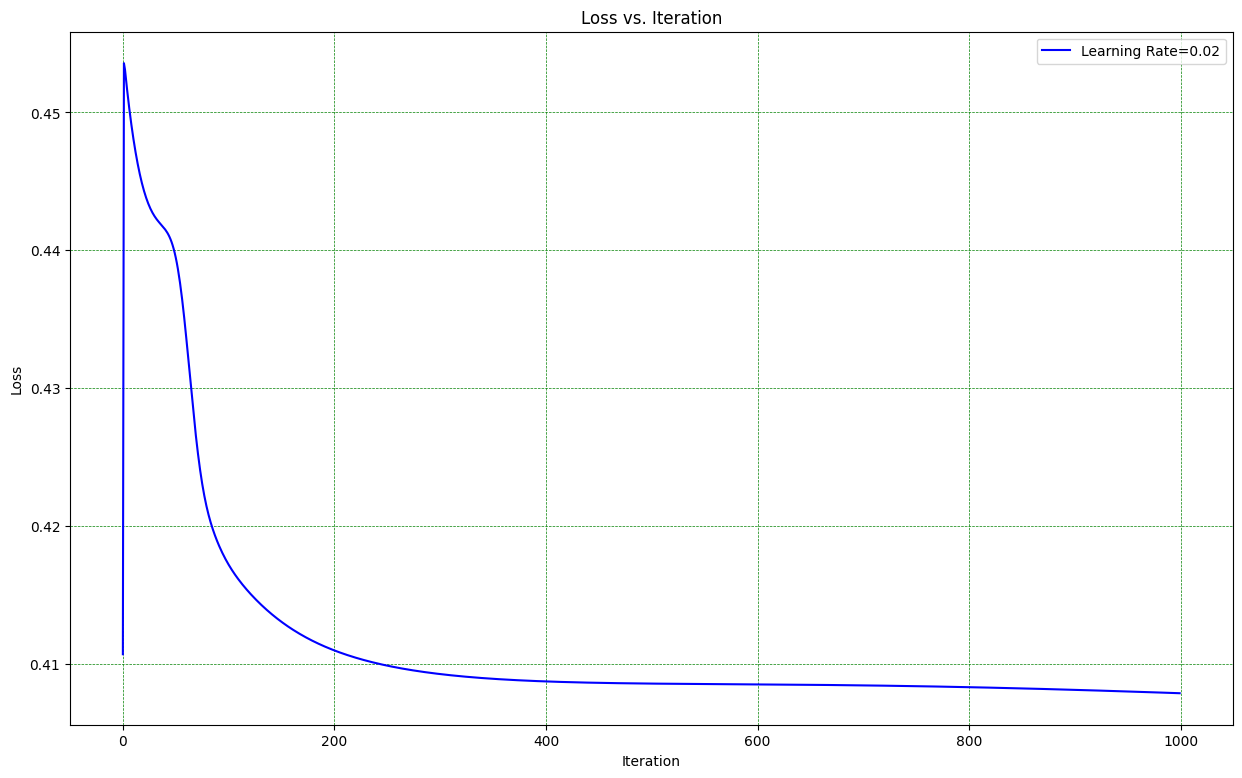

In [108]:
plt.figure(figsize=(15,9))
plt.plot(range(iteration), own_losses, label=f"Learning Rate={eta}", color="b")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Iteration")
plt.grid(True, color="green", linestyle="--", linewidth=0.5)
plt.show()

<h4 style="color:blue">Learning Curves Comparsion for Different Step Sizes</h4>

In [109]:
def plot_losses_per_eta(losses_per_eta, etas):
    plt.figure(figsize=(15, 8))
    for eta, losses in zip(etas, losses_per_eta):
        plt.plot(range(len(losses)), losses, label=f"Step Size (Learning Rate)={eta}")

    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss vs. Iteration for Different Step Sizes (Learning Rates)")
    plt.grid(True, color="green", linestyle="--", linewidth=0.5)
    plt.show()

In [110]:
own_losses_per_eta = []
iteration = 1000;
etas = [0.0001, 0.001, 0.01, 0.02]
for eta in etas:
    losses = stochasticGradientDescent(sF, sdF, d, data, iteration, eta)
    own_losses_per_eta.append(losses)

iteration 0: w = [-0.05989698  0.00017186  0.00135182], F(w) = 0.6931471805599453
iteration 1: w = [-0.07211746  0.0004181   0.00355799], F(w) = 0.6931471805599453
iteration 2: w = [-0.07619953  0.00067831  0.00592341], F(w) = 0.6931471805599453
iteration 3: w = [-0.07775588  0.00094292  0.00833914], F(w) = 0.6931471805599453
iteration 4: w = [-0.07838782  0.00120907  0.01077267], F(w) = 0.6931471805599453
iteration 5: w = [-0.07866154  0.00147573  0.01321229], F(w) = 0.6931471805599453
iteration 6: w = [-0.07879339  0.0017425   0.0156535 ], F(w) = 0.6931471805599453
iteration 7: w = [-0.07886853  0.00200923  0.01809451], F(w) = 0.6931471805599453
iteration 8: w = [-0.07892093  0.00227584  0.02053461], F(w) = 0.6931471805599453
iteration 9: w = [-0.07896418  0.00254232  0.02297351], F(w) = 0.6931471805599453
iteration 10: w = [-0.07900375  0.00280865  0.02541112], F(w) = 0.6931471805599453
iteration 11: w = [-0.07904184  0.00307484  0.02784737], F(w) = 0.6931471805599453
iteration 12: 

iteration 129: w = [-0.08338003  0.03343962  0.30581575], F(w) = 0.6931471805599453
iteration 130: w = [-0.08341644  0.03368827  0.30809253], F(w) = 0.6931471805599453
iteration 131: w = [-0.08345285  0.03393678  0.31036801], F(w) = 0.6931471805599453
iteration 132: w = [-0.08348925  0.03418515  0.31264219], F(w) = 0.6931471805599453
iteration 133: w = [-0.08352564  0.03443338  0.31491508], F(w) = 0.6931471805599453
iteration 134: w = [-0.08356203  0.03468146  0.31718667], F(w) = 0.6931471805599453
iteration 135: w = [-0.0835984   0.03492941  0.31945698], F(w) = 0.6931471805599453
iteration 136: w = [-0.08363478  0.03517721  0.32172599], F(w) = 0.6931471805599453
iteration 137: w = [-0.08367115  0.03542487  0.3239937 ], F(w) = 0.6931471805599453
iteration 138: w = [-0.08370751  0.03567238  0.32626013], F(w) = 0.6931471805599453
iteration 139: w = [-0.08374386  0.03591976  0.32852527], F(w) = 0.6931471805599453
iteration 140: w = [-0.08378021  0.03616699  0.33078912], F(w) = 0.693147180

iteration 231: w = [-0.08706098  0.05808323  0.53150503], F(w) = 0.6931471805599453
iteration 232: w = [-0.08709673  0.0583178   0.53365365], F(w) = 0.6931471805599453
iteration 233: w = [-0.08713247  0.05855224  0.53580106], F(w) = 0.6931471805599453
iteration 234: w = [-0.0871682   0.05878655  0.53794725], F(w) = 0.6931471805599453
iteration 235: w = [-0.08720393  0.05902072  0.54009223], F(w) = 0.6931471805599453
iteration 236: w = [-0.08723965  0.05925476  0.542236  ], F(w) = 0.6931471805599453
iteration 237: w = [-0.08727536  0.05948866  0.54437856], F(w) = 0.6931471805599453
iteration 238: w = [-0.08731107  0.05972244  0.5465199 ], F(w) = 0.6931471805599453
iteration 239: w = [-0.08734677  0.05995608  0.54866003], F(w) = 0.6931471805599453
iteration 240: w = [-0.08738246  0.06018958  0.55079896], F(w) = 0.6931471805599453
iteration 241: w = [-0.08741814  0.06042296  0.55293667], F(w) = 0.6931471805599453
iteration 242: w = [-0.08745382  0.0606562   0.55507318], F(w) = 0.693147180

iteration 330: w = [-0.09056598  0.08067384  0.73845136], F(w) = 0.6931471805599453
iteration 331: w = [-0.09060102  0.08089567  0.74048363], F(w) = 0.6931471805599453
iteration 332: w = [-0.09063606  0.08111737  0.74251476], F(w) = 0.6931471805599453
iteration 333: w = [-0.09067109  0.08133896  0.74454477], F(w) = 0.6931471805599453
iteration 334: w = [-0.09070612  0.08156042  0.74657363], F(w) = 0.6931471805599453
iteration 335: w = [-0.09074113  0.08178176  0.74860137], F(w) = 0.6931471805599453
iteration 336: w = [-0.09077614  0.08200297  0.75062798], F(w) = 0.6931471805599453
iteration 337: w = [-0.09081114  0.08222406  0.75265345], F(w) = 0.6931471805599453
iteration 338: w = [-0.09084614  0.08244503  0.7546778 ], F(w) = 0.6931471805599453
iteration 339: w = [-0.09088113  0.08266587  0.75670101], F(w) = 0.6931471805599453
iteration 340: w = [-0.09091611  0.08288659  0.7587231 ], F(w) = 0.6931471805599453
iteration 341: w = [-0.09095108  0.08310719  0.76074406], F(w) = 0.693147180

iteration 451: w = [-0.0947524   0.10664399  0.97635463], F(w) = 0.6931471805599453
iteration 452: w = [-0.09478653  0.10685153  0.97825553], F(w) = 0.6931471805599453
iteration 453: w = [-0.09482066  0.10705897  0.9801554 ], F(w) = 0.6931471805599453
iteration 454: w = [-0.09485478  0.10726629  0.98205423], F(w) = 0.6931471805599453
iteration 455: w = [-0.09488889  0.10747349  0.98395203], F(w) = 0.6931471805599453
iteration 456: w = [-0.094923    0.10768059  0.9858488 ], F(w) = 0.6931471805599453
iteration 457: w = [-0.0949571   0.10788758  0.98774453], F(w) = 0.6931471805599453
iteration 458: w = [-0.09499119  0.10809445  0.98963922], F(w) = 0.6931471805599453
iteration 459: w = [-0.09502527  0.10830121  0.99153289], F(w) = 0.6931471805599453
iteration 460: w = [-0.09505934  0.10850786  0.99342553], F(w) = 0.6931471805599453
iteration 461: w = [-0.09509341  0.1087144   0.99531713], F(w) = 0.6931471805599453
iteration 462: w = [-0.09512747  0.10892083  0.99720771], F(w) = 0.693147180

iteration 577: w = [-0.09899224  0.13194176  1.20796113], F(w) = 0.6931471805599453
iteration 578: w = [-0.09902539  0.13213591  1.20973757], F(w) = 0.6931471805599453
iteration 579: w = [-0.09905854  0.13232995  1.21151308], F(w) = 0.6931471805599453
iteration 580: w = [-0.09909167  0.1325239   1.21328765], F(w) = 0.6931471805599453
iteration 581: w = [-0.0991248   0.13271774  1.21506128], F(w) = 0.6931471805599453
iteration 582: w = [-0.09915792  0.13291149  1.21683397], F(w) = 0.6931471805599453
iteration 583: w = [-0.09919103  0.13310513  1.21860573], F(w) = 0.6931471805599453
iteration 584: w = [-0.09922413  0.13329868  1.22037655], F(w) = 0.6931471805599453
iteration 585: w = [-0.09925723  0.13349213  1.22214643], F(w) = 0.6931471805599453
iteration 586: w = [-0.09929032  0.13368547  1.22391539], F(w) = 0.6931471805599453
iteration 587: w = [-0.0993234   0.13387872  1.22568341], F(w) = 0.6931471805599453
iteration 588: w = [-0.09935647  0.13407186  1.22745049], F(w) = 0.693147180

iteration 709: w = [-0.10329974  0.15673331  1.43460535], F(w) = 0.6931471805599453
iteration 710: w = [-0.10333185  0.15691495  1.43626409], F(w) = 0.6931471805599453
iteration 711: w = [-0.10336395  0.1570965   1.43792199], F(w) = 0.6931471805599453
iteration 712: w = [-0.10339604  0.15727795  1.43957905], F(w) = 0.6931471805599453
iteration 713: w = [-0.10342812  0.15745933  1.44123526], F(w) = 0.6931471805599453
iteration 714: w = [-0.10346019  0.15764061  1.44289063], F(w) = 0.6931471805599453
iteration 715: w = [-0.10349226  0.1578218   1.44454516], F(w) = 0.6931471805599453
iteration 716: w = [-0.10352432  0.1580029   1.44619884], F(w) = 0.6931471805599453
iteration 717: w = [-0.10355637  0.15818392  1.44785169], F(w) = 0.6931471805599453
iteration 718: w = [-0.10358841  0.15836485  1.4495037 ], F(w) = 0.6931471805599453
iteration 719: w = [-0.10362044  0.15854569  1.45115486], F(w) = 0.6931471805599453
iteration 720: w = [-0.10365247  0.15872644  1.45280519], F(w) = 0.693147180

iteration 822: w = [-0.10687762  0.1767131   1.61685415], F(w) = 0.6931471805599453
iteration 823: w = [-0.10690883  0.17688517  1.61842163], F(w) = 0.6931471805599453
iteration 824: w = [-0.10694004  0.17705716  1.61998834], F(w) = 0.6931471805599453
iteration 825: w = [-0.10697124  0.17722907  1.62155428], F(w) = 0.6931471805599453
iteration 826: w = [-0.10700243  0.17740089  1.62311945], F(w) = 0.6931471805599453
iteration 827: w = [-0.10703361  0.17757264  1.62468385], F(w) = 0.6931471805599453
iteration 828: w = [-0.10706478  0.17774431  1.62624749], F(w) = 0.6931471805599453
iteration 829: w = [-0.10709595  0.1779159   1.62781035], F(w) = 0.6931471805599453
iteration 830: w = [-0.10712711  0.17808741  1.62937245], F(w) = 0.6931471805599453
iteration 831: w = [-0.10715826  0.17825883  1.63093378], F(w) = 0.6931471805599453
iteration 832: w = [-0.1071894   0.17843018  1.63249435], F(w) = 0.6931471805599453
iteration 833: w = [-0.10722054  0.17860145  1.63405415], F(w) = 0.693147180

iteration 951: w = [-0.11083988  0.19827213  1.81290656], F(w) = 0.6931471805599453
iteration 952: w = [-0.1108701   0.19843443  1.81437956], F(w) = 0.6931471805599453
iteration 953: w = [-0.1109003   0.19859665  1.81585186], F(w) = 0.6931471805599453
iteration 954: w = [-0.1109305   0.19875881  1.81732347], F(w) = 0.6931471805599453
iteration 955: w = [-0.11096069  0.1989209   1.81879439], F(w) = 0.6931471805599453
iteration 956: w = [-0.11099087  0.19908291  1.82026461], F(w) = 0.6931471805599453
iteration 957: w = [-0.11102105  0.19924485  1.82173414], F(w) = 0.6931471805599453
iteration 958: w = [-0.11105122  0.19940672  1.82320297], F(w) = 0.6931471805599453
iteration 959: w = [-0.11108138  0.19956852  1.82467112], F(w) = 0.6931471805599453
iteration 960: w = [-0.11111153  0.19973025  1.82613857], F(w) = 0.6931471805599453
iteration 961: w = [-0.11114167  0.19989191  1.82760534], F(w) = 0.6931471805599453
iteration 962: w = [-0.11117181  0.2000535   1.82907141], F(w) = 0.693147180

iteration 85: w = [-0.16643647  0.16255742  1.49720199], F(w) = 0.6931471805599453
iteration 86: w = [-0.16668184  0.1641327   1.5116535 ], F(w) = 0.6931471805599453
iteration 87: w = [-0.16692638  0.16570204  1.52604646], F(w) = 0.6931471805599453
iteration 88: w = [-0.16717012  0.1672655   1.5403812 ], F(w) = 0.6931471805599453
iteration 89: w = [-0.16741304  0.16882311  1.55465807], F(w) = 0.6931471805599453
iteration 90: w = [-0.16765514  0.17037492  1.56887739], F(w) = 0.6931471805599453
iteration 91: w = [-0.16789644  0.17192097  1.58303951], F(w) = 0.6931471805599453
iteration 92: w = [-0.16813692  0.17346131  1.59714475], F(w) = 0.6931471805599453
iteration 93: w = [-0.16837659  0.17499597  1.61119344], F(w) = 0.6931471805599453
iteration 94: w = [-0.16861546  0.17652501  1.6251859 ], F(w) = 0.6931471805599453
iteration 95: w = [-0.16885352  0.17804846  1.63912248], F(w) = 0.6931471805599453
iteration 96: w = [-0.16909077  0.17956637  1.65300348], F(w) = 0.6931471805599453
iter

iteration 201: w = [-0.19035916  0.31487915  2.85675587], F(w) = 0.6931471805599453
iteration 202: w = [-0.19053515  0.31599095  2.86625631], F(w) = 0.6931471805599453
iteration 203: w = [-0.19071076  0.31710019  2.8757269 ], F(w) = 0.6931471805599453
iteration 204: w = [-0.19088599  0.31820689  2.8851678 ], F(w) = 0.6931471805599453
iteration 205: w = [-0.19106084  0.31931108  2.89457918], F(w) = 0.6931471805599453
iteration 206: w = [-0.19123532  0.32041276  2.90396121], F(w) = 0.6931471805599453
iteration 207: w = [-0.19140943  0.32151195  2.91331405], F(w) = 0.6931471805599453
iteration 208: w = [-0.19158318  0.32260868  2.92263785], F(w) = 0.6931471805599453
iteration 209: w = [-0.19175655  0.32370295  2.93193279], F(w) = 0.6931471805599453
iteration 210: w = [-0.19192956  0.32479478  2.94119902], F(w) = 0.6931471805599453
iteration 211: w = [-0.19210221  0.32588419  2.9504367 ], F(w) = 0.6931471805599453
iteration 212: w = [-0.19227449  0.3269712   2.95964598], F(w) = 0.693147180

iteration 327: w = [-0.21009151  0.43920591  3.86306286], F(w) = 0.6931471805599453
iteration 328: w = [-0.21023185  0.44009316  3.86980534], F(w) = 0.6931471805599453
iteration 329: w = [-0.21037198  0.44097918  3.87653201], F(w) = 0.6931471805599453
iteration 330: w = [-0.21051189  0.44186399  3.88324293], F(w) = 0.6931471805599453
iteration 331: w = [-0.2106516   0.44274757  3.88993818], F(w) = 0.6931471805599453
iteration 332: w = [-0.21079109  0.44362995  3.89661783], F(w) = 0.6931471805599453
iteration 333: w = [-0.21093037  0.44451113  3.90328195], F(w) = 0.6931471805599453
iteration 334: w = [-0.21106945  0.44539111  3.90993061], F(w) = 0.6931471805599453
iteration 335: w = [-0.21120831  0.4462699   3.91656387], F(w) = 0.6931471805599453
iteration 336: w = [-0.21134697  0.4471475   3.9231818 ], F(w) = 0.6931471805599453
iteration 337: w = [-0.21148542  0.44802392  3.92978447], F(w) = 0.6931471805599453
iteration 338: w = [-0.21162366  0.44889917  3.93637195], F(w) = 0.693147180

iteration 427: w = [-0.2231806   0.52269147  4.46896263], F(w) = 0.6931471805599453
iteration 428: w = [-0.22330286  0.52348024  4.47441375], F(w) = 0.6931471805599453
iteration 429: w = [-0.22342496  0.52426822  4.47985439], F(w) = 0.6931471805599453
iteration 430: w = [-0.22354691  0.52505542  4.48528459], F(w) = 0.6931471805599453
iteration 431: w = [-0.22366871  0.52584184  4.49070439], F(w) = 0.6931471805599453
iteration 432: w = [-0.22379035  0.52662748  4.49611383], F(w) = 0.6931471805599453
iteration 433: w = [-0.22391185  0.52741234  4.50151294], F(w) = 0.6931471805599453
iteration 434: w = [-0.22403319  0.52819644  4.50690178], F(w) = 0.6931471805599453
iteration 435: w = [-0.22415438  0.52897977  4.51228036], F(w) = 0.6931471805599453
iteration 436: w = [-0.22427542  0.52976233  4.51764874], F(w) = 0.6931471805599453
iteration 437: w = [-0.22439631  0.53054413  4.52300695], F(w) = 0.6931471805599453
iteration 438: w = [-0.22451706  0.53132517  4.52835503], F(w) = 0.693147180

iteration 529: w = [-0.23492887  0.59956158  4.97697282], F(w) = 0.6931471805599453
iteration 530: w = [-0.23503745  0.60028353  4.98152698], F(w) = 0.6931471805599453
iteration 531: w = [-0.23514591  0.60100493  4.98607379], F(w) = 0.6931471805599453
iteration 532: w = [-0.23525425  0.60172579  4.99061328], F(w) = 0.6931471805599453
iteration 533: w = [-0.23536248  0.6024461   4.99514547], F(w) = 0.6931471805599453
iteration 534: w = [-0.23547059  0.60316588  4.99967038], F(w) = 0.6931471805599453
iteration 535: w = [-0.23557858  0.60388513  5.00418805], F(w) = 0.6931471805599453
iteration 536: w = [-0.23568646  0.60460383  5.00869848], F(w) = 0.6931471805599453
iteration 537: w = [-0.23579422  0.60532201  5.0132017 ], F(w) = 0.6931471805599453
iteration 538: w = [-0.23590187  0.60603965  5.01769774], F(w) = 0.6931471805599453
iteration 539: w = [-0.2360094   0.60675676  5.02218662], F(w) = 0.6931471805599453
iteration 540: w = [-0.23611682  0.60747335  5.02666837], F(w) = 0.693147180

iteration 651: w = [-0.24738159  0.68408391  5.48446371], F(w) = 0.6931471805599453
iteration 652: w = [-0.24747759  0.68475048  5.48826788], F(w) = 0.6931471805599453
iteration 653: w = [-0.2475735   0.68541667  5.49206693], F(w) = 0.6931471805599453
iteration 654: w = [-0.24766933  0.68608249  5.49586086], F(w) = 0.6931471805599453
iteration 655: w = [-0.24776506  0.68674793  5.4996497 ], F(w) = 0.6931471805599453
iteration 656: w = [-0.24786071  0.68741299  5.50343344], F(w) = 0.6931471805599453
iteration 657: w = [-0.24795626  0.68807768  5.50721212], F(w) = 0.6931471805599453
iteration 658: w = [-0.24805172  0.688742    5.51098574], F(w) = 0.6931471805599453
iteration 659: w = [-0.2481471   0.68940595  5.51475432], F(w) = 0.6931471805599453
iteration 660: w = [-0.24824238  0.69006952  5.51851786], F(w) = 0.6931471805599453
iteration 661: w = [-0.24833758  0.69073272  5.52227639], F(w) = 0.6931471805599453
iteration 662: w = [-0.24843269  0.69139556  5.52602992], F(w) = 0.693147180

iteration 756: w = [-0.25699781  0.75218277  5.85826667], F(w) = 0.6931471805599453
iteration 757: w = [-0.25708516  0.75281452  5.86159897], F(w) = 0.6931471805599453
iteration 758: w = [-0.25717244  0.75344598  5.86492735], F(w) = 0.6931471805599453
iteration 759: w = [-0.25725964  0.75407715  5.8682518 ], F(w) = 0.6931471805599453
iteration 760: w = [-0.25734677  0.75470803  5.87157235], F(w) = 0.6931471805599453
iteration 761: w = [-0.25743382  0.75533862  5.87488899], F(w) = 0.6931471805599453
iteration 762: w = [-0.2575208   0.75596893  5.87820174], F(w) = 0.6931471805599453
iteration 763: w = [-0.25760771  0.75659894  5.88151061], F(w) = 0.6931471805599453
iteration 764: w = [-0.25769454  0.75722867  5.8848156 ], F(w) = 0.6931471805599453
iteration 765: w = [-0.25778129  0.75785812  5.88811673], F(w) = 0.6931471805599453
iteration 766: w = [-0.25786797  0.75848728  5.891414  ], F(w) = 0.6931471805599453
iteration 767: w = [-0.25795458  0.75911615  5.89470743], F(w) = 0.693147180

iteration 859: w = [-0.26562246  0.81583696  6.18236391], F(w) = 0.6931471805599453
iteration 860: w = [-0.2657027   0.81644196  6.1853351 ], F(w) = 0.6931471805599453
iteration 861: w = [-0.26578288  0.81704672  6.18830318], F(w) = 0.6931471805599453
iteration 862: w = [-0.265863    0.81765126  6.19126814], F(w) = 0.6931471805599453
iteration 863: w = [-0.26594306  0.81825556  6.19422999], F(w) = 0.6931471805599453
iteration 864: w = [-0.26602305  0.81885963  6.19718873], F(w) = 0.6931471805599453
iteration 865: w = [-0.26610297  0.81946347  6.20014439], F(w) = 0.6931471805599453
iteration 866: w = [-0.26618284  0.82006709  6.20309695], F(w) = 0.6931471805599453
iteration 867: w = [-0.26626264  0.82067047  6.20604643], F(w) = 0.6931471805599453
iteration 868: w = [-0.26634238  0.82127363  6.20899284], F(w) = 0.6931471805599453
iteration 869: w = [-0.26642206  0.82187655  6.21193617], F(w) = 0.6931471805599453
iteration 870: w = [-0.26650167  0.82247925  6.21487645], F(w) = 0.693147180

iteration 975: w = [-0.27453035  0.88457972  6.50773019], F(w) = 0.6931471805599453
iteration 976: w = [-0.27460382  0.88516062  6.51037836], F(w) = 0.6931471805599453
iteration 977: w = [-0.27467724  0.88574134  6.51302406], F(w) = 0.6931471805599453
iteration 978: w = [-0.2747506   0.88632188  6.51566728], F(w) = 0.6931471805599453
iteration 979: w = [-0.27482392  0.88690223  6.51830803], F(w) = 0.6931471805599453
iteration 980: w = [-0.27489717  0.88748239  6.52094631], F(w) = 0.6931471805599453
iteration 981: w = [-0.27497038  0.88806237  6.52358213], F(w) = 0.6931471805599453
iteration 982: w = [-0.27504353  0.88864217  6.52621549], F(w) = 0.6931471805599453
iteration 983: w = [-0.27511663  0.88922178  6.52884641], F(w) = 0.6931471805599453
iteration 984: w = [-0.27518968  0.88980121  6.53147487], F(w) = 0.6931471805599453
iteration 985: w = [-0.27526267  0.89038046  6.53410089], F(w) = 0.6931471805599453
iteration 986: w = [-0.27533561  0.89095952  6.53672448], F(w) = 0.693147180

iteration 83: w = [-0.37942042  0.38839165  4.29489163], F(w) = 0.6931471805599453
iteration 84: w = [-0.37967848  0.39162439  4.32419862], F(w) = 0.6931471805599453
iteration 85: w = [-0.37997806  0.39484354  4.3530762 ], F(w) = 0.6931471805599453
iteration 86: w = [-0.38031223  0.39804985  4.38154038], F(w) = 0.6931471805599453
iteration 87: w = [-0.38067543  0.40124399  4.40960706], F(w) = 0.6931471805599453
iteration 88: w = [-0.38106325  0.40442656  4.43729202], F(w) = 0.6931471805599453
iteration 89: w = [-0.38147222  0.40759811  4.46461074], F(w) = 0.6931471805599453
iteration 90: w = [-0.3818997   0.41075917  4.49157835], F(w) = 0.6931471805599453
iteration 91: w = [-0.38234362  0.41391019  4.51820952], F(w) = 0.6931471805599453
iteration 92: w = [-0.38280234  0.41705163  4.54451841], F(w) = 0.6931471805599453
iteration 93: w = [-0.38327454  0.4201839   4.57051861], F(w) = 0.6931471805599453
iteration 94: w = [-0.3837591   0.42330739  4.59622308], F(w) = 0.6931471805599453
iter

iteration 182: w = [-0.42776789  0.68227551  6.25761175], F(w) = 0.6931471805599453
iteration 183: w = [-0.42819066  0.68512408  6.2721737 ], F(w) = 0.6931471805599453
iteration 184: w = [-0.42861206  0.68797148  6.28666969], F(w) = 0.6931471805599453
iteration 185: w = [-0.4290321   0.69081774  6.3011004 ], F(w) = 0.6931471805599453
iteration 186: w = [-0.42945078  0.69366287  6.3154665 ], F(w) = 0.6931471805599453
iteration 187: w = [-0.42986812  0.69650689  6.32976865], F(w) = 0.6931471805599453
iteration 188: w = [-0.43028412  0.69934981  6.34400749], F(w) = 0.6931471805599453
iteration 189: w = [-0.43069879  0.70219165  6.35818366], F(w) = 0.6931471805599453
iteration 190: w = [-0.43111215  0.70503242  6.37229779], F(w) = 0.6931471805599453
iteration 191: w = [-0.4315242   0.70787215  6.38635049], F(w) = 0.6931471805599453
iteration 192: w = [-0.43193495  0.71071084  6.40034237], F(w) = 0.6931471805599453
iteration 193: w = [-0.43234441  0.71354851  6.41427404], F(w) = 0.693147180

iteration 294: w = [-0.46822215  0.99648845  7.58682176], F(w) = 0.6931471805599453
iteration 295: w = [-0.46853227  0.99926337  7.59664756], F(w) = 0.6931471805599453
iteration 296: w = [-0.46884166  1.0020379   7.60644605], F(w) = 0.6931471805599453
iteration 297: w = [-0.46915031  1.00481202  7.61621741], F(w) = 0.6931471805599453
iteration 298: w = [-0.46945823  1.00758575  7.62596179], F(w) = 0.6931471805599453
iteration 299: w = [-0.46976542  1.0103591   7.63567936], F(w) = 0.6931471805599453
iteration 300: w = [-0.47007188  1.01313205  7.64537027], F(w) = 0.6931471805599453
iteration 301: w = [-0.47037762  1.01590461  7.65503468], F(w) = 0.6931471805599453
iteration 302: w = [-0.47068265  1.01867679  7.66467275], F(w) = 0.6931471805599453
iteration 303: w = [-0.47098695  1.02144858  7.67428463], F(w) = 0.6931471805599453
iteration 304: w = [-0.47129054  1.02421999  7.68387048], F(w) = 0.6931471805599453
iteration 305: w = [-0.47159342  1.02699103  7.69343045], F(w) = 0.693147180

iteration 404: w = [-0.49850929  1.29971192  8.53206552], F(w) = 0.6931471805599453
iteration 405: w = [-0.49875391  1.30245258  8.53961328], F(w) = 0.6931471805599453
iteration 406: w = [-0.49899804  1.305193    8.54714525], F(w) = 0.6931471805599453
iteration 407: w = [-0.49924169  1.30793317  8.5546615 ], F(w) = 0.6931471805599453
iteration 408: w = [-0.49948486  1.3106731   8.5621621 ], F(w) = 0.6931471805599453
iteration 409: w = [-0.49972756  1.31341279  8.5696471 ], F(w) = 0.6931471805599453
iteration 410: w = [-0.49996977  1.31615224  8.57711657], F(w) = 0.6931471805599453
iteration 411: w = [-0.50021151  1.31889144  8.58457058], F(w) = 0.6931471805599453
iteration 412: w = [-0.50045278  1.32163041  8.59200919], F(w) = 0.6931471805599453
iteration 413: w = [-0.50069357  1.32436914  8.59943245], F(w) = 0.6931471805599453
iteration 414: w = [-0.50093389  1.32710763  8.60684044], F(w) = 0.6931471805599453
iteration 415: w = [-0.50117374  1.32984588  8.6142332 ], F(w) = 0.693147180

iteration 512: w = [-0.52240252  1.59446501  9.26711654], F(w) = 0.6931471805599453
iteration 513: w = [-0.52260211  1.59718411  9.27325637], F(w) = 0.6931471805599453
iteration 514: w = [-0.52280133  1.59990306  9.27938538], F(w) = 0.6931471805599453
iteration 515: w = [-0.52300019  1.60262185  9.2855036 ], F(w) = 0.6931471805599453
iteration 516: w = [-0.52319869  1.60534048  9.29161105], F(w) = 0.6931471805599453
iteration 517: w = [-0.52339683  1.60805896  9.29770777], F(w) = 0.6931471805599453
iteration 518: w = [-0.52359462  1.61077729  9.30379379], F(w) = 0.6931471805599453
iteration 519: w = [-0.52379204  1.61349546  9.30986915], F(w) = 0.6931471805599453
iteration 520: w = [-0.5239891   1.61621348  9.31593386], F(w) = 0.6931471805599453
iteration 521: w = [-0.52418581  1.61893134  9.32198797], F(w) = 0.6931471805599453
iteration 522: w = [-0.52438216  1.62164906  9.3280315 ], F(w) = 0.6931471805599453
iteration 523: w = [-0.52457816  1.62436662  9.33406448], F(w) = 0.693147180

iteration 637: w = [-0.54476294  1.93334964  9.9592728 ], F(w) = 0.6931471805599453
iteration 638: w = [-0.54492241  1.93605423  9.96425788], F(w) = 0.6931471805599453
iteration 639: w = [-0.5450816   1.93875875  9.96923502], F(w) = 0.6931471805599453
iteration 640: w = [-0.5452405   1.9414632   9.97420423], F(w) = 0.6931471805599453
iteration 641: w = [-0.54539912  1.94416756  9.97916553], F(w) = 0.6931471805599453
iteration 642: w = [-0.54555745  1.94687185  9.98411895], F(w) = 0.6931471805599453
iteration 643: w = [-0.54571551  1.94957607  9.98906448], F(w) = 0.6931471805599453
iteration 644: w = [-0.54587328  1.95228021  9.99400216], F(w) = 0.6931471805599453
iteration 645: w = [-0.54603077  1.95498428  9.99893199], F(w) = 0.6931471805599453
iteration 646: w = [-0.54618798  1.95768827 10.003854  ], F(w) = 0.6931471805599453
iteration 647: w = [-0.54634491  1.96039219 10.0087682 ], F(w) = 0.6931471805599453
iteration 648: w = [-0.54650156  1.96309603 10.0136746 ], F(w) = 0.693147180

iteration 744: w = [-0.56030702  2.22240481 10.45059005], F(w) = 0.6931471805599453
iteration 745: w = [-0.5604387   2.22510397 10.45480682], F(w) = 0.6931471805599453
iteration 746: w = [-0.56057015  2.22780311 10.45901708], F(w) = 0.6931471805599453
iteration 747: w = [-0.56070137  2.23050223 10.46322084], F(w) = 0.6931471805599453
iteration 748: w = [-0.56083234  2.23320132 10.46741813], F(w) = 0.6931471805599453
iteration 749: w = [-0.56096309  2.23590038 10.47160894], F(w) = 0.6931471805599453
iteration 750: w = [-0.5610936   2.23859942 10.47579329], F(w) = 0.6931471805599453
iteration 751: w = [-0.56122387  2.24129844 10.47997119], F(w) = 0.6931471805599453
iteration 752: w = [-0.56135391  2.24399743 10.48414265], F(w) = 0.6931471805599453
iteration 753: w = [-0.56148372  2.2466964  10.48830768], F(w) = 0.6931471805599453
iteration 754: w = [-0.5616133   2.24939534 10.49246629], F(w) = 0.6931471805599453
iteration 755: w = [-0.56174265  2.25209427 10.4966185 ], F(w) = 0.693147180

iteration 861: w = [-0.57422192  2.53812076 10.90243603], F(w) = 0.6931471805599453
iteration 862: w = [-0.5743288   2.54081914 10.90595854], F(w) = 0.6931471805599453
iteration 863: w = [-0.57443549  2.54351753 10.90947564], F(w) = 0.6931471805599453
iteration 864: w = [-0.57454199  2.54621594 10.91298734], F(w) = 0.6931471805599453
iteration 865: w = [-0.57464831  2.54891435 10.91649365], F(w) = 0.6931471805599453
iteration 866: w = [-0.57475443  2.55161278 10.91999458], F(w) = 0.6931471805599453
iteration 867: w = [-0.57486037  2.55431121 10.92349013], F(w) = 0.6931471805599453
iteration 868: w = [-0.57496612  2.55700966 10.92698032], F(w) = 0.6931471805599453
iteration 869: w = [-0.57507169  2.55970811 10.93046514], F(w) = 0.6931471805599453
iteration 870: w = [-0.57517707  2.56240658 10.93394462], F(w) = 0.6931471805599453
iteration 871: w = [-0.57528226  2.56510506 10.93741875], F(w) = 0.6931471805599453
iteration 872: w = [-0.57538727  2.56780355 10.94088755], F(w) = 0.693147180

iteration 978: w = [-0.58553888  2.85394474 11.27988502], F(w) = 0.6931471805599453
iteration 979: w = [-0.58562607  2.8566454  11.28282646], F(w) = 0.6931471805599453
iteration 980: w = [-0.58571312  2.85934609 11.28576335], F(w) = 0.6931471805599453
iteration 981: w = [-0.58580002  2.8620468  11.2886957 ], F(w) = 0.6931471805599453
iteration 982: w = [-0.58588677  2.86474754 11.29162351], F(w) = 0.6931471805599453
iteration 983: w = [-0.58597337  2.86744831 11.29454681], F(w) = 0.6931471805599453
iteration 984: w = [-0.58605983  2.8701491  11.29746558], F(w) = 0.6931471805599453
iteration 985: w = [-0.58614613  2.87284992 11.30037984], F(w) = 0.6931471805599453
iteration 986: w = [-0.5862323   2.87555077 11.30328959], F(w) = 0.6931471805599453
iteration 987: w = [-0.58631831  2.87825164 11.30619485], F(w) = 0.6931471805599453
iteration 988: w = [-0.58640418  2.88095254 11.30909561], F(w) = 0.6931471805599453
iteration 989: w = [-0.5864899   2.88365347 11.31199189], F(w) = 0.693147180

iteration 115: w = [-0.46534649  0.52434863  5.41389867], F(w) = 0.6931471805599453
iteration 116: w = [-0.46616942  0.52732125  5.43916736], F(w) = 0.6931471805599453
iteration 117: w = [-0.46698937  0.53028841  5.46431345], F(w) = 0.6931471805599453
iteration 118: w = [-0.46780639  0.53325026  5.48933804], F(w) = 0.6931471805599453
iteration 119: w = [-0.46862048  0.53620695  5.51424222], F(w) = 0.6931471805599453
iteration 120: w = [-0.46943167  0.53915861  5.53902707], F(w) = 0.6931471805599453
iteration 121: w = [-0.47023997  0.54210539  5.56369363], F(w) = 0.6931471805599453
iteration 122: w = [-0.47104542  0.54504741  5.58824295], F(w) = 0.6931471805599453
iteration 123: w = [-0.47184801  0.54798481  5.61267605], F(w) = 0.6931471805599453
iteration 124: w = [-0.47264778  0.55091773  5.63699394], F(w) = 0.6931471805599453
iteration 125: w = [-0.47344474  0.55384628  5.6611976 ], F(w) = 0.6931471805599453
iteration 126: w = [-0.4742389   0.55677061  5.68528802], F(w) = 0.693147180

iteration 265: w = [-0.56284185  0.95734346  8.23682916], F(w) = 0.6931471805599453
iteration 266: w = [-0.56335465  0.96032641  8.25099471], F(w) = 0.6931471805599453
iteration 267: w = [-0.56386607  0.96331182  8.26511627], F(w) = 0.6931471805599453
iteration 268: w = [-0.56437612  0.96629971  8.2791941 ], F(w) = 0.6931471805599453
iteration 269: w = [-0.5648848   0.96929007  8.29322844], F(w) = 0.6931471805599453
iteration 270: w = [-0.56539213  0.97228292  8.30721953], F(w) = 0.6931471805599453
iteration 271: w = [-0.5658981   0.97527826  8.32116762], F(w) = 0.6931471805599453
iteration 272: w = [-0.56640273  0.9782761   8.33507294], F(w) = 0.6931471805599453
iteration 273: w = [-0.56690603  0.98127644  8.34893574], F(w) = 0.6931471805599453
iteration 274: w = [-0.567408    0.9842793   8.36275624], F(w) = 0.6931471805599453
iteration 275: w = [-0.56790864  0.98728467  8.37653469], F(w) = 0.6931471805599453
iteration 276: w = [-0.56840797  0.99029257  8.39027132], F(w) = 0.693147180

iteration 370: w = [-0.61032649  1.28460545  9.52295874], F(w) = 0.6931471805599453
iteration 371: w = [-0.61072682  1.2878585   9.53357566], F(w) = 0.6931471805599453
iteration 372: w = [-0.61112633  1.29111404  9.54416694], F(w) = 0.6931471805599453
iteration 373: w = [-0.61152503  1.29437207  9.55473269], F(w) = 0.6931471805599453
iteration 374: w = [-0.61192291  1.29763257  9.56527303], F(w) = 0.6931471805599453
iteration 375: w = [-0.61231997  1.30089554  9.57578809], F(w) = 0.6931471805599453
iteration 376: w = [-0.61271624  1.30416098  9.58627797], F(w) = 0.6931471805599453
iteration 377: w = [-0.61311169  1.30742889  9.59674279], F(w) = 0.6931471805599453
iteration 378: w = [-0.61350635  1.31069926  9.60718267], F(w) = 0.6931471805599453
iteration 379: w = [-0.61390021  1.31397209  9.61759773], F(w) = 0.6931471805599453
iteration 380: w = [-0.61429328  1.31724737  9.62798807], F(w) = 0.6931471805599453
iteration 381: w = [-0.61468555  1.3205251   9.63835382], F(w) = 0.693147180

iteration 505: w = [-0.65812761  1.74439872 10.76381223], F(w) = 0.6931471805599453
iteration 506: w = [-0.65844214  1.74794465 10.7718053 ], F(w) = 0.6931471805599453
iteration 507: w = [-0.65875618  1.75149242 10.77978379], F(w) = 0.6931471805599453
iteration 508: w = [-0.65906972  1.75504202 10.78774775], F(w) = 0.6931471805599453
iteration 509: w = [-0.65938278  1.75859344 10.79569723], F(w) = 0.6931471805599453
iteration 510: w = [-0.65969535  1.76214668 10.80363228], F(w) = 0.6931471805599453
iteration 511: w = [-0.66000743  1.76570173 10.81155297], F(w) = 0.6931471805599453
iteration 512: w = [-0.66031903  1.7692586  10.81945934], F(w) = 0.6931471805599453
iteration 513: w = [-0.66063015  1.77281727 10.82735145], F(w) = 0.6931471805599453
iteration 514: w = [-0.66094079  1.77637774 10.83522935], F(w) = 0.6931471805599453
iteration 515: w = [-0.66125095  1.77994    10.8430931 ], F(w) = 0.6931471805599453
iteration 516: w = [-0.66156063  1.78350406 10.85094273], F(w) = 0.693147180

iteration 623: w = [-0.69222173  2.17426444 11.61892865], F(w) = 0.6931471805599453
iteration 624: w = [-0.69248751  2.17799607 11.62551213], F(w) = 0.6931471805599453
iteration 625: w = [-0.69275294  2.18172903 11.63208588], F(w) = 0.6931471805599453
iteration 626: w = [-0.69301803  2.18546333 11.63864993], F(w) = 0.6931471805599453
iteration 627: w = [-0.69328277  2.18919895 11.64520431], F(w) = 0.6931471805599453
iteration 628: w = [-0.69354717  2.19293589 11.65174905], F(w) = 0.6931471805599453
iteration 629: w = [-0.69381123  2.19667415 11.65828417], F(w) = 0.6931471805599453
iteration 630: w = [-0.69407495  2.20041372 11.66480972], F(w) = 0.6931471805599453
iteration 631: w = [-0.69433832  2.2041546  11.67132571], F(w) = 0.6931471805599453
iteration 632: w = [-0.69460136  2.2078968  11.67783218], F(w) = 0.6931471805599453
iteration 633: w = [-0.69486406  2.21164029 11.68432916], F(w) = 0.6931471805599453
iteration 634: w = [-0.69512642  2.21538509 11.69081668], F(w) = 0.693147180

iteration 753: w = [-0.7241708   2.6693612  12.40271222], F(w) = 0.6931471805599453
iteration 754: w = [-0.72439835  2.67323903 12.4082443 ], F(w) = 0.6931471805599453
iteration 755: w = [-0.72462564  2.6771178  12.41376968], F(w) = 0.6931471805599453
iteration 756: w = [-0.72485269  2.6809975  12.41928838], F(w) = 0.6931471805599453
iteration 757: w = [-0.72507949  2.68487814 12.42480042], F(w) = 0.6931471805599453
iteration 758: w = [-0.72530604  2.68875971 12.43030581], F(w) = 0.6931471805599453
iteration 759: w = [-0.72553235  2.6926422  12.43580458], F(w) = 0.6931471805599453
iteration 760: w = [-0.7257584   2.69652563 12.44129673], F(w) = 0.6931471805599453
iteration 761: w = [-0.72598422  2.70040997 12.44678229], F(w) = 0.6931471805599453
iteration 762: w = [-0.72620979  2.70429524 12.45226126], F(w) = 0.6931471805599453
iteration 763: w = [-0.72643511  2.70818143 12.45773368], F(w) = 0.6931471805599453
iteration 764: w = [-0.72666019  2.71206853 12.46319956], F(w) = 0.693147180

iteration 862: w = [-0.7476188   3.09708813 12.96961425], F(w) = 0.6931471805599453
iteration 863: w = [-0.74782224  3.10105514 12.97450656], F(w) = 0.6931471805599453
iteration 864: w = [-0.74802549  3.10502285 12.97939374], F(w) = 0.6931471805599453
iteration 865: w = [-0.74822853  3.10899127 12.9842758 ], F(w) = 0.6931471805599453
iteration 866: w = [-0.74843139  3.1129604  12.98915275], F(w) = 0.6931471805599453
iteration 867: w = [-0.74863404  3.11693023 12.9940246 ], F(w) = 0.6931471805599453
iteration 868: w = [-0.74883651  3.12090077 12.99889137], F(w) = 0.6931471805599453
iteration 869: w = [-0.74903878  3.124872   13.00375306], F(w) = 0.6931471805599453
iteration 870: w = [-0.74924086  3.12884393 13.00860968], F(w) = 0.6931471805599453
iteration 871: w = [-0.74944274  3.13281655 13.01346125], F(w) = 0.6931471805599453
iteration 872: w = [-0.74964443  3.13678987 13.01830778], F(w) = 0.6931471805599453
iteration 873: w = [-0.74984593  3.14076388 13.02314928], F(w) = 0.693147180

iteration 988: w = [-0.77182983  3.60197843 13.54902945], F(w) = 0.6931471805599453
iteration 989: w = [-0.77201141  3.60602222 13.55335459], F(w) = 0.6931471805599453
iteration 990: w = [-0.77219283  3.61006654 13.55767578], F(w) = 0.6931471805599453
iteration 991: w = [-0.7723741   3.61411138 13.56199303], F(w) = 0.6931471805599453
iteration 992: w = [-0.77255521  3.61815673 13.56630636], F(w) = 0.6931471805599453
iteration 993: w = [-0.77273618  3.6222026  13.57061575], F(w) = 0.6931471805599453
iteration 994: w = [-0.77291699  3.62624899 13.57492124], F(w) = 0.6931471805599453
iteration 995: w = [-0.77309765  3.63029589 13.57922281], F(w) = 0.6931471805599453
iteration 996: w = [-0.77327815  3.6343433  13.58352049], F(w) = 0.6931471805599453
iteration 997: w = [-0.77345851  3.63839123 13.58781427], F(w) = 0.6931471805599453
iteration 998: w = [-0.77363871  3.64243967 13.59210417], F(w) = 0.6931471805599453
iteration 999: w = [-0.77381877  3.64648862 13.59639019], F(w) = 0.693147180

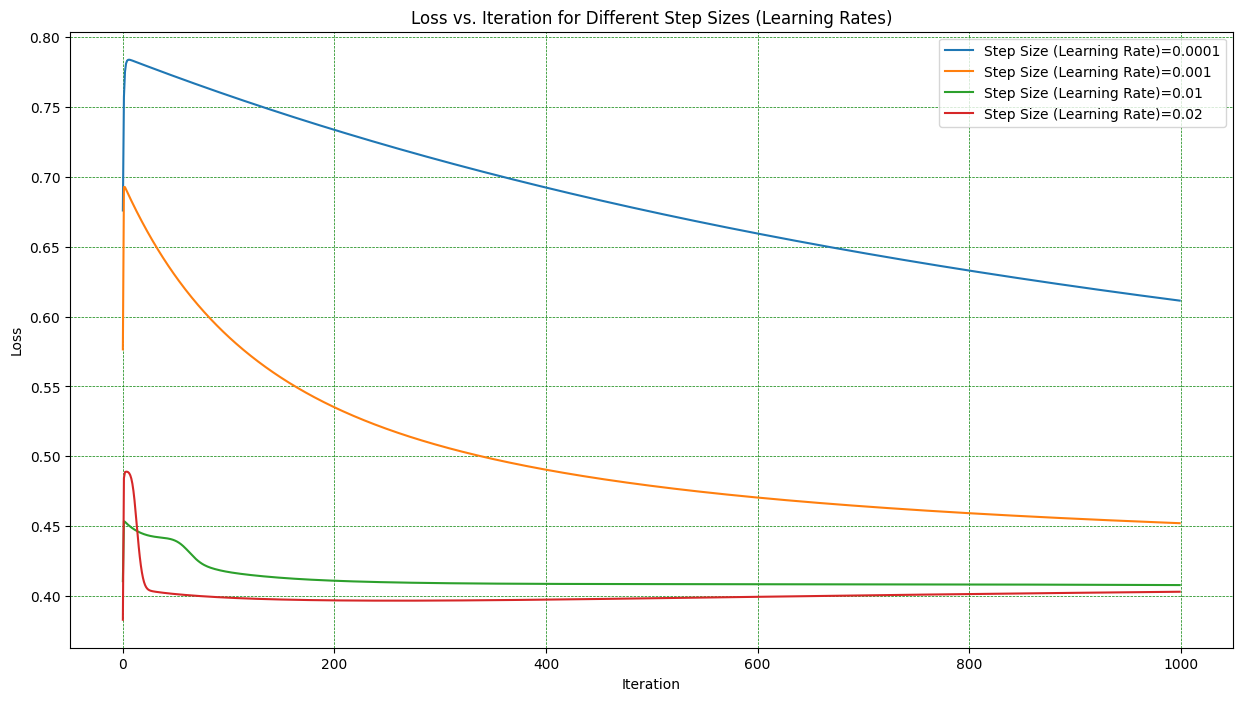

In [111]:
plot_losses_per_eta(own_losses_per_eta, etas)

<ul><li>
<h4 style="color:purple">Task 3 : Built-in Linear Predictor</h4></li></ul>

In [112]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

LR.fit(X_train, y_train)

score = LR.score(X_test, y_test)

print('Score:', score)
warnings.filterwarnings('ignore')

Score: 0.98


<h4 style="color:blue">Iterations vs loss</h4>

In [113]:
step_size = 0.02
line_color = 'r'

builtIn_losses = []
num_iterations = [5, 20, 40, 90, 120]
iteration_losses = []

In [114]:
for n in num_iterations:
    LR = LogisticRegression(C=step_size)
    LR.max_iter = n
    LR.fit(X_train, y_train)
    y_train_proba = LR.predict_proba(X_train)

    train_log_loss = log_loss(y_train, y_train_proba)

    iteration_losses.append(train_log_loss)

builtIn_losses.append(iteration_losses)

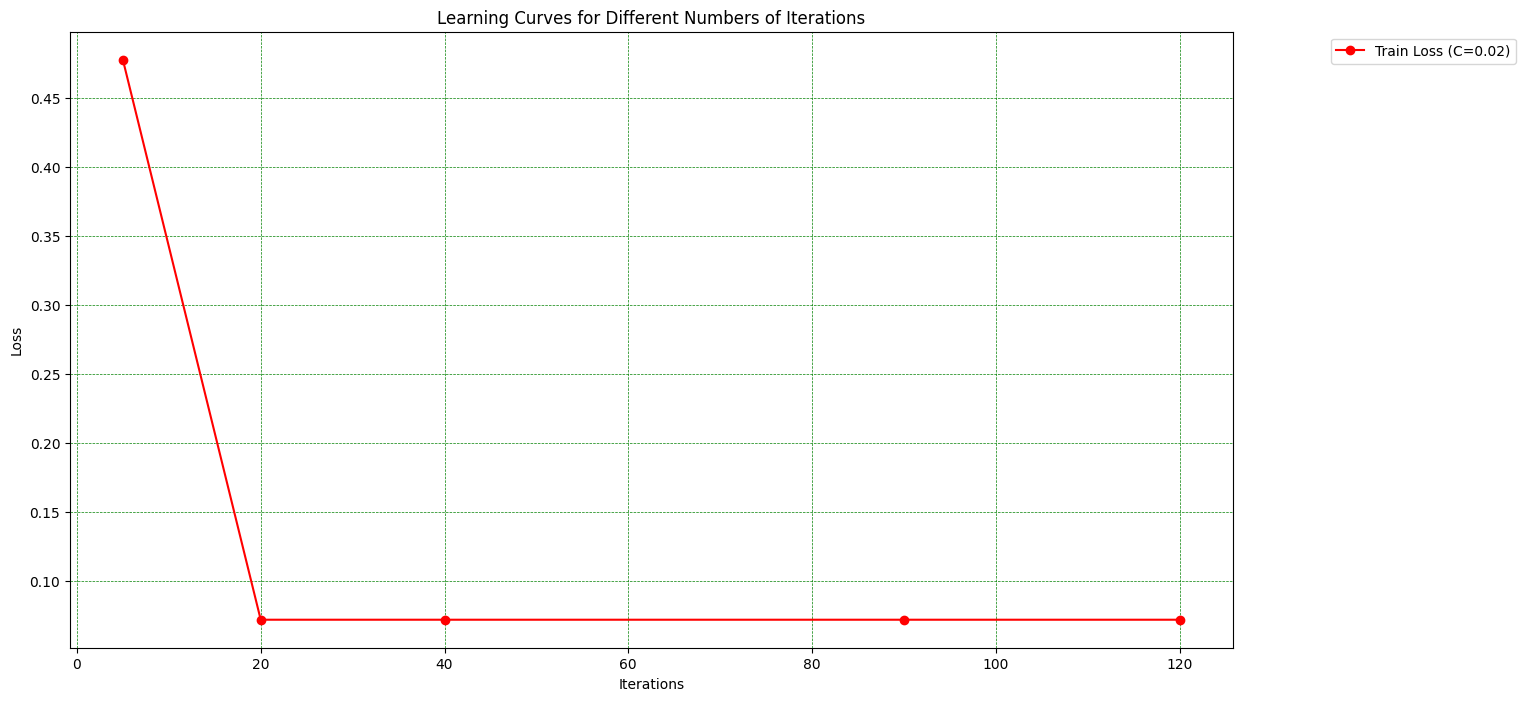

In [115]:
plt.figure(figsize=(15, 8))

plt.plot(num_iterations, builtIn_losses[0], label=f"Train Loss (C={step_size})", color=line_color, linestyle='-', marker='o')

plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

plt.title("Learning Curves for Different Numbers of Iterations")
plt.grid(True, color="green", linestyle="--", linewidth=0.5)

plt.show()

<h4 style="color:blue">Learning Curves Comparsion for Different Step Sizes</h4>

In [116]:
step_sizes = [0.0001, 0.001, 0.01, 0.02]
line_colors = ['b', 'g', 'r', 'c']
builtIn_losses_per_eta = []

In [117]:
for step_size in step_sizes:
    LR = LogisticRegression(max_iter=n, C=step_size)

    num_iterations = [5, 20, 40, 90, 120]
    iteration_losses = []

    for n in num_iterations:
        LR.max_iter = n
        LR.fit(X_train, y_train)
        y_train_pred = LR.predict_proba(X_train)

        train_log_loss = log_loss(y_train, y_train_pred)

        iteration_losses.append(train_log_loss)

    builtIn_losses_per_eta.append(iteration_losses)


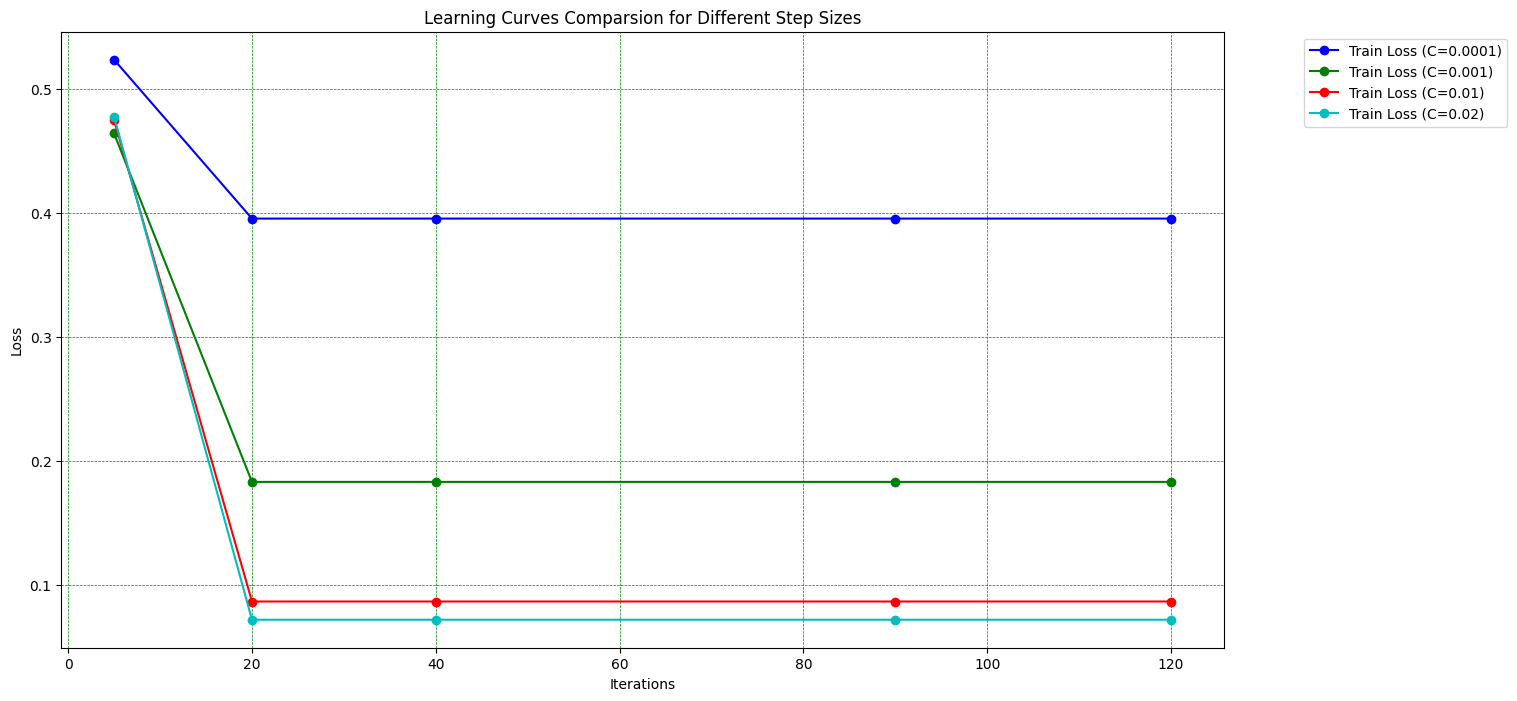

In [118]:
plt.figure(figsize=(15, 8))
for i, step_size in enumerate(step_sizes):
    plt.plot(num_iterations, builtIn_losses_per_eta[i], label=f"Train Loss (C={step_size})", color=line_colors[i], linestyle='-', marker='o')

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

plt.title("Learning Curves Comparsion for Different Step Sizes")
plt.grid(True, color="green", linestyle="--", linewidth=0.5)
plt.show()

<ul><li>
<h4 style="color:purple">Task 4 : Predictor Learning Curve Comparison </h4></li></ul>

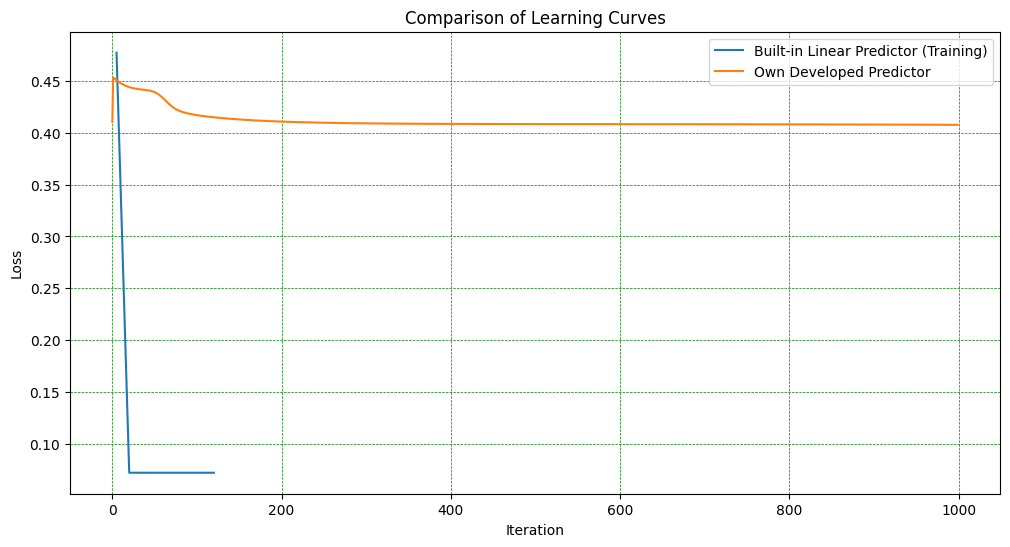

In [120]:
plt.figure(figsize=(12, 6))

plt.plot(num_iterations, builtIn_losses[0], label="Built-in Linear Predictor (Training)")
plt.plot(range(1000), own_losses, label="Own Developed Predictor")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.title("Comparison of Learning Curves")
plt.grid(True, color="green", linestyle="--", linewidth=0.5)
plt.show()

<p style="color:green"> Own Predictor Best learning Curve for step size = 0.02 and Built-in Predictor best learning curver for step size = 0.02 with minimum losses of 0.4 and less then 0.10 respectively for 1000 and different number of iteration respectively.</p>

<h5>Submitted By</h5>
<ul style="color:purple">
    <li>Nasir Hussain</li>
    <li>04072013040</li>
    <li>BS Computer Science VII</li>
    <li>CS-414 Artificial Intelligence</li>
</ul>